In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [3]:
def vec(X: np.ndarray) -> np.ndarray:
    return X.T.reshape(-1)


def mat(x: np.ndarray, shape: tuple) -> np.ndarray:
    return x.reshape((shape[1], shape[0])).T


In [4]:
np.random.seed(0)

M = 3
N = 4
T = 5

X = np.random.normal(size=(N, T, M))
WT = np.random.normal(size=(M, T))
WN = np.random.normal(size=(N, M))

WT

array([[-0.672, -0.36 , -0.813, -1.726,  0.177],
       [-0.402, -1.63 ,  0.463, -0.907,  0.052],
       [ 0.729,  0.129,  1.139, -1.235,  0.402]])

In [3]:
from ndgsp import Graph, ProductGraph
from ndgsp import MultivariateFilterFunction

from PIL import Image
import matplotlib.patches as mpatches
import matplotlib
import scipy as sp
from scipy.sparse import csr_array
from scipy.optimize import minimize


from typing import Callable
from typing import Tuple
from scipy.sparse.linalg import LinearOperator, cg

import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch

import subprocess 

import time
from tqdm.notebook import tqdm

import sys

sys.path.append('..')
sys.path.append('.')

from utils.plotting import to_colors
from gsr import GSR2D

import ast
import json


Using Jax backend with device gpu:0


In [4]:
np.random.seed(1)

x = 2 * np.random.uniform(0, 10, size=10)
y = 2 * np.random.uniform(0, 10, size=10)
z = np.zeros_like(x)

In [56]:
def verify_eig_of_path_graph():
    """
    This function demonstrates that the eigenvalues and eigenvectors
    of the path graph are as given in the thesis
    """


    T = 101
    G = Graph.chain(T)

    # compute eigen-decomposition using closed-form solution 
    lam = 2 - 2 * np.cos(T ** -1 * np.pi * np.arange(T))
    U = np.cos(T ** -1 * np.pi * np.outer(np.arange(T) + 0.5, np.arange(T)))
    U /= np.linalg.norm(U, axis=0)

    # check the decomposition recreates the Laplacian
    assert np.allclose(G.L, U @ np.diag(lam) @ U.T)

    return True


verify_eig_of_path_graph()

True

In [75]:
def verify_DCT():
    """
    This function verifies that the GFT and the IGFT are given by the Discrete 
    Cosine Transform (DCT) and the Inverse DCT respectively. 
    """

    def Uy(y):
        return sp.fft.idct(y.T, type=2, norm='ortho').T

    def UTy(y):
        return sp.fft.dct(y.T, type=2, norm='ortho').T

    def yU(y):
        return sp.fft.dct(y, type=2, norm='ortho')

    def yUT(y):
        return sp.fft.idct(y, type=2, norm='ortho')

    T = 101

    # compute eigen-decomposition using closed-form solution 
    U = np.cos(T ** -1 * np.pi * np.outer(np.arange(T) + 0.5, np.arange(T)))
    U /= np.linalg.norm(U, axis=0)

    for shape in [(T), (T, 5), (5, T)]:

        y = np.random.normal(size=shape)
        
        if shape != (5, T):
            assert np.allclose(U.T @ y, UTy(y))
            assert np.allclose(U @ y, Uy(y))

        if shape != (T, 5):
            assert np.allclose(y @ U.T, yUT(y))
            assert np.allclose(y @ U, yU(y))

    return True

verify_DCT()


True

  0%|          | 0/20 [00:00<?, ?it/s]

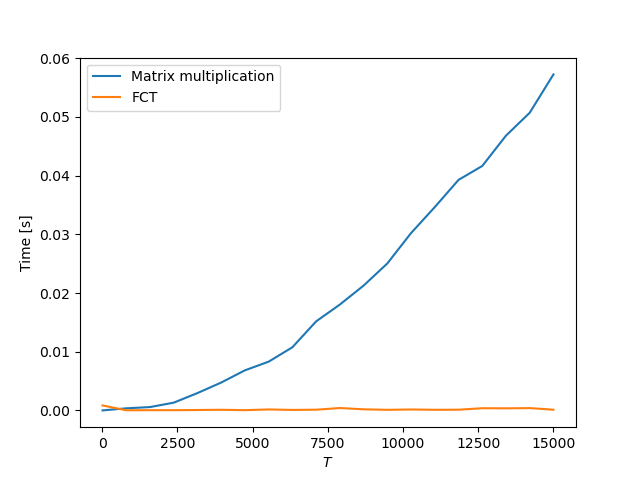

In [27]:
def plot_MM_vs_CDT(save=False):
    """
    Plot a graph demonstrating the difference in compute time across a range 
    of T values for matrix multiplication vs the DCT for GFT of the path graph. 
    """

    Ts = np.linspace(10, 1.5e4, 20).astype(int)
    ts_gft = []
    ts_dct = []

    for T in tqdm(Ts):

        U = np.cos( np.pi * np.outer(np.arange(T) + 0.5, np.arange(T)) / T)
        U /= np.linalg.norm(U, axis=0)

        y = np.random.normal(size=T)

        t0 = time.time()
        for i in range(5):
            U.T @ y
        ts_gft.append((time.time() - t0) / 5)

        t0 = time.time()
        for i in range(5):
            sp.fft.dct(y, type=2, norm='ortho')
        ts_dct.append((time.time() - t0) / 5)

    plt.figure()

    plt.plot(Ts, ts_gft, label='Matrix multiplication')
    plt.plot(Ts, ts_dct, label='FCT')

    plt.legend()

    plt.xlabel('$T$')
    plt.ylabel('Time [s]')

    plt.xticks(np.arange(0, 15001, 2500))

    if save:

        plt.savefig('DCT.pdf', transparent=True)

    
plot_MM_vs_CDT()

In [1]:
from scipy.integrate import quad

In [12]:
lmax = 4

lam = np.linspace(0, lmax, 200)

def c(k, h):
    if k == 0:
        return 1 / np.pi * quad(lambda theta: h(lmax / 2 * (np.cos(theta) + 1)), 0, np.pi)[0]
    else:
        return 2 / np.pi * quad(lambda theta: np.cos(k * theta) * h(lmax / 2 * (np.cos(theta) + 1)), 0, np.pi)[0] 


def T(lam, k):
    
    if k == 0:
        return np.ones_like(lam)
    
    elif k == 1:
        return 2 * lam / lmax - 1
    
    return (4 * lam / lmax - 2) * T(lam, k-1) - T(lam, k-2)

def approximate(h, K):

    return sum(c(kk, h) * T(lam, kk) for kk in range(K+1))


filters = {'diffusion': lambda l, b: np.exp(-b * l),
           '1-hop': lambda l, b: (1 + b * l) ** -1,
           'relu': lambda l, b: np.maximum(1 - b * l, 0),
           'sigmoid': lambda l, b: 2 * (1 + np.exp(b * l)) ** -1,
           'gaussian': lambda l, b: np.exp(-(b * l) ** 2),
           'bandlimited': lambda l, b: (b * l <= 1).astype(float)}

In [23]:
import subprocess

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `Cheb/cheb_approx_raw.pdf'.


CompletedProcess(args=['pdfcrop', 'Cheb/cheb_approx_raw.pdf', 'Cheb/cheb_approx_raw.pdf'], returncode=0)

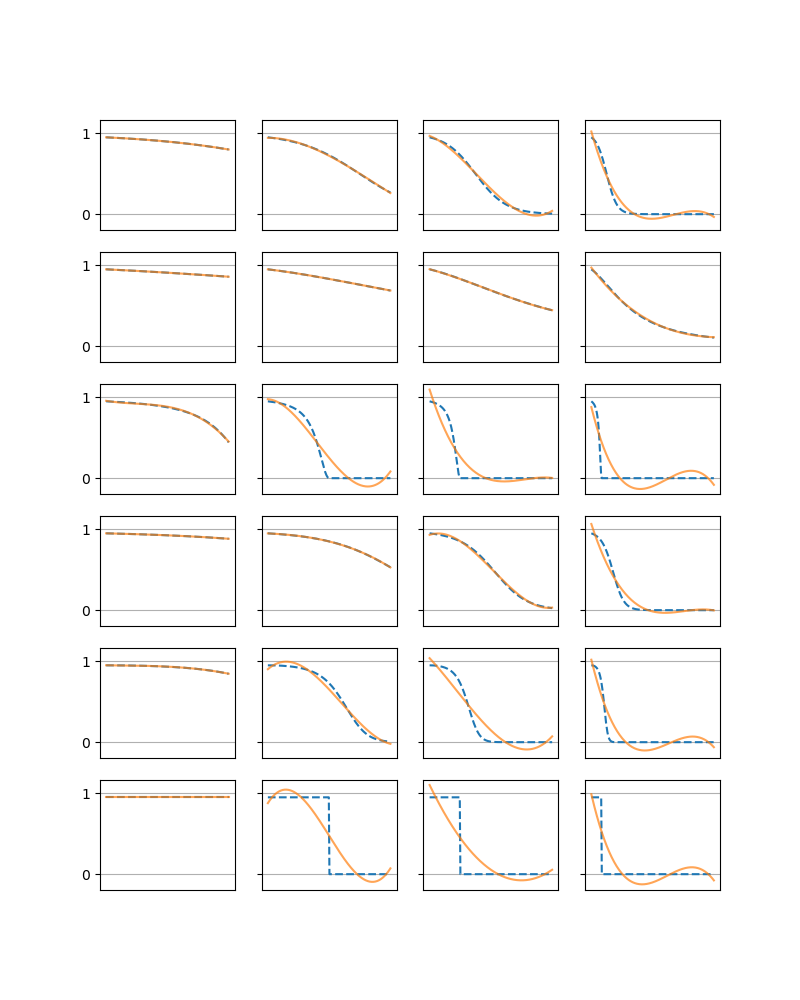

In [33]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(8, 10), sharex=True, sharey=True)

for i, fil in enumerate(filters):

    betas = [0.2, 0.5, 1, 3]

    for j in range(4):
        
        axes[i, j].plot(lam, filters[fil](lam, betas[j]) ** 2 / (filters[fil](lam, betas[j]) ** 2 + 0.05), ls='--')
        axes[i, j].plot(lam, approximate(lambda x: filters[fil](x, betas[j]) ** 2 / (filters[fil](x, betas[j]) ** 2 + 0.05), 3), alpha=0.7)

        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([0, 1])
        axes[i, j].grid()

plt.savefig('Cheb/cheb_approx_raw.pdf')

subprocess.run(['pdfcrop', 'Cheb/cheb_approx_raw.pdf', 'Cheb/cheb_approx_raw.pdf'])

In [31]:
def get_uk_covid_data():

    regions = pd.read_csv('../data/uk/regions.csv', index_col=0)
    regions['coords'] = regions['coords'].apply(lambda item: ast.literal_eval(item))   
    cases = pd.read_csv('../data/uk/case_rate_per_thousand.csv', index_col=0, parse_dates=True)

    return regions, cases

    

In [32]:
regions, cases = get_uk_covid_data()

In [33]:
def get_district_graph():

    paths = {code: [Path(np.squeeze(coords)) for coords in coords_list] for code, coords_list in zip(regions.index.tolist(), regions['coords'])}

    A = np.zeros((len(paths), len(paths)))

    for i, plist1 in tqdm(enumerate(paths.values()), total=A.shape[0]):

        for j, plist2 in enumerate(paths.values()):

            if i == j:
                break

            for path1 in plist1:
                for path2 in plist2:
                    if path1.intersects_path(path2):
                        A[i, j] = 1
                        A[j, i] = 1

    L  = np.diag(A.sum(0)) - A
    
    return A, L


def get_path_graph(N: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get the adjacency matrix and Laplacian for a path graph

    Params:
        N       The number of nodes

    Returns:
        A       (N, N) adjacency matrix        
        L       (N, N) Laplacian matrix
    """

    A = np.zeros((N, N))
    A[range(N-1), range(1, N)] = 1
    A += A.T
    L = np.diag(A.sum(0)) - A

    return A, L


def get_centroids():
        
    paths = {code: [Path(np.squeeze(coords)) for coords in coords_list] for code, coords_list in zip(regions.index.tolist(), regions['coords'])}
    centroids = np.array([max(path_list, key= lambda path: len(path)).vertices.mean(0) for path_list in paths.values()])

    return centroids


In [34]:
AT, LT = get_path_graph(cases.shape[0])
AN, LN = get_district_graph()

  0%|          | 0/372 [00:00<?, ?it/s]

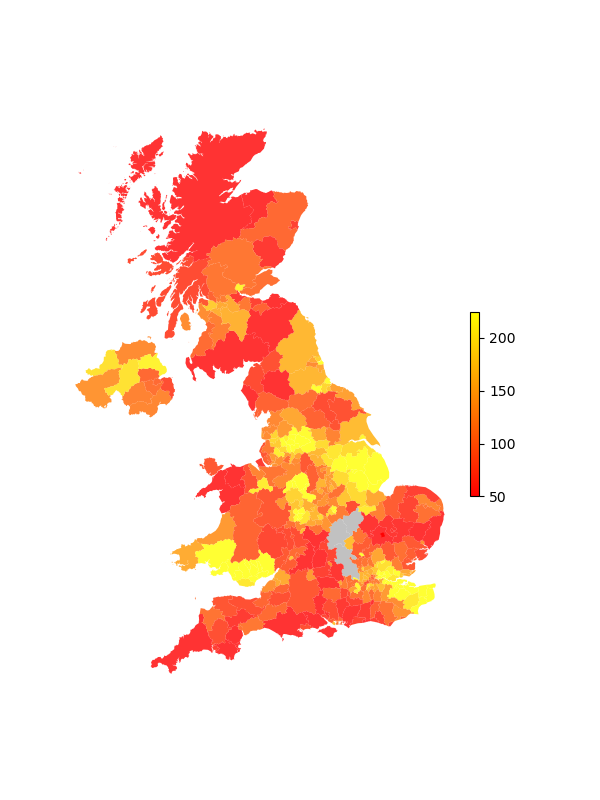

In [35]:
def plot_uk_covid(save=False):
    
    patches = {}
    t = 300

    vmin = 50
    vmax = 225
    colors = to_colors(cases.iloc[t].values, cmap='autumn', vmin=vmin, vmax=vmax)
    fig, ax = plt.subplots(figsize=(6, 8))

    for code, coord_list, color in zip(regions.index, regions['coords'], colors):
        patches[code] = []

        for coords in coord_list:

            coords = np.squeeze(coords)
            patches[code].append(ax.add_patch(PathPatch(Path(coords), alpha=0.8, facecolor=color, edgecolor='white', linewidth=0)))

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='autumn'), ax=ax, shrink=0.3, drawedges=False)

    ax.set_xlim(0, 0.66e6)
    ax.set_ylim(0, 0.98e6)
    ax.set_aspect('equal')
    plt.axis('off')

    if save:

        plt.savefig('UK_covid.pdf')
        subprocess.run(['pdfcrop', 'UK_covid.pdf', 'UK_covid.pdf'])

plot_uk_covid()


In [36]:
Y0 = np.log(10 + cases)

Y0 = (Y0 - Y0.stack().mean()) / Y0.stack().std()

In [37]:
def remove_random_uniform(Y0, m: float, seed: int=0):
    """
    Add nans to a signal uniformly at random, such that a total fraction
    of approximately m is removed
    """

    np.random.seed(seed)
    non_nulls = np.argwhere(~Y0.isnull().values)
    N = len(non_nulls)
    M = int(m * N)
    inds = non_nulls[np.random.choice(N, size=M, replace=False)]
    Y1 = Y0.copy()
    Y1.values[inds[:, 0], inds[:, 1]] = np.nan

    return Y1, Y1.isnull() & (~Y0.isnull())


def remove_random_strings(Y0, m: float, str_len: int=100, seed: int=0):    
    """
    Add nans to a signal by randomly selecting strings of dates to be removed
    at each node, such that a total fraction of approximately m is removed
    """

    np.random.seed(seed)

    all_out = []
    for i in range(Y0.shape[1]):

        t = 0
        out = np.zeros(Y0.shape[0], dtype=bool)

        while t < Y0.shape[0] - str_len:

            if np.random.uniform(0, 1) < ((1 + 1.5 * m) * m / str_len):
                out[t:t+str_len] = True
                t += str_len

            else:
                t += 1

        all_out.append(out)

    Y1 = Y0.copy()
    Y1.values[np.array(all_out).T] = np.nan

    return Y1, Y1.isnull() & (~Y0.isnull())


def remove_random_nodes(Y0, m: float, seed: int=0):
    """
    Add nans to a signal by randomly removing the entire time series for a particular 
    node such that a total fraction of approximately m is removed
    """


    np.random.seed(seed)

    n_cols = int(m * Y0.shape[1])

    Y1 = Y0.copy()

    Y1.iloc[:, np.random.choice(Y0.shape[1], size=n_cols, replace=False)] = np.nan

    return Y1, Y1.isnull() & (~Y0.isnull())

def remove_random_times(Y0, m: float, seed: int=0):
    """
    Add nans to a signal by randomly removing the signal at all nodes for a particular 
    time such that a total fraction of approximately m is removed
    """

    np.random.seed(seed)

    n_rows = int(m * Y0.shape[0])
    
    Y1 = Y0.copy()

    Y1.iloc[np.random.choice(Y0.shape[0], size=n_rows, replace=False), :] = np.nan

    return Y1, Y1.isnull() & (~Y0.isnull())
    

In [38]:
def get_RMSE(Y0, predicted_inds, F):
    return (np.nansum((Y0.values[predicted_inds.values] - F.values[predicted_inds.values]) ** 2) / predicted_inds.values.sum()) ** 0.5

In [39]:
def interpolate_linear(Y1):
    return Y1.interpolate().ffill().bfill().fillna(0)

def longitudinal_average(Y1):
    return Y1.T.fillna(Y1.mean(1)).T.fillna(0)



In [40]:
def optimise(Y0, Y1, inds, x0=[1e-2, 3.0, 3.0], max_time=10):

    t0 = time.time()

    model = GSR2D(LT, LN, 1e-2, [3.0, 3.0], 'diffusion')
    hist = {'gamma': [], 'beta1': [], 'beta2': [], 'rmse': []}

    def set_params(params):

        gamma, beta1, beta2 = np.exp(params)
        model.gamma = gamma
        model.beta = [beta1, beta2]

        return gamma, beta1, beta2

    def target(params):
        
        gamma, beta1, beta2 = set_params(params)
        F, nits = model.predict(Y1.T)
        rmse = get_RMSE(Y0, inds, F.T)

        for value, name in zip([gamma, beta1, beta2, rmse], ['gamma', 'beta1', 'beta2', 'rmse']):
            hist[name].append(value)

        print(f'Params: γ={gamma:.3e}, β=[{beta1:.3e} {beta2:.3e}]. RMSE={rmse:.6e}. Nits: {nits}', end="\r")

        if time.time() - t0 > max_time * 60:
            raise KeyboardInterrupt

        return rmse
        
    try:
        params = minimize(target, x0=np.log(x0), method='Nelder-Mead').x
    except KeyboardInterrupt:
        pass 

    i_best = np.argmin(hist['rmse'])
    gamma_best,  beta1_best, beta2_best = [hist[param][i_best] for param in ['gamma', 'beta1', 'beta2']]
    F, nits = model.predict(Y1.T)
    rmse = get_RMSE(Y0, inds, F.T)

    print(f'Params: γ={gamma_best:.3e}, β=[{beta1_best:.3e} {beta2_best:.3e}]. RMSE={rmse:.6e}. Nits: {nits}')
    
    return hist, model



In [55]:
with open('best_params.json') as f:
    p = json.load(f)

In [56]:
ms = [0.1, 0.3, 0.5, 0.7, 0.9]
method_names = ['uniform', 'strings', 'districts', 'dates']
methods = [remove_random_uniform, remove_random_strings, remove_random_nodes, remove_random_times]

rmses = {method_name: {model: {} for model in ['GSR', 'lin', 'lon']} for method_name in method_names}

for m in tqdm([0.1, 0.3, 0.5, 0.7]):
    
    for method, method_name in zip(methods, method_names):

        Y1, inds = method(Y0, m=m)

        gamma, beta1, beta2 = [p[method_name][str(m)][param] for param in ['gamma', 'beta1', 'beta2']]

        model = GSR2D(LT, LN, gamma=gamma, beta=[beta1, beta2])
        F, nits = model.predict(Y1.T)

        rmses[method_name]['GSR'][str(m)] = f'{get_RMSE(Y0, inds, F.T):.3f}'

        if method_name != 'districts':
            rmses[method_name]['lin'][str(m)] = f'{get_RMSE(Y0, inds, interpolate_linear(Y1)):.3f}'

        if method_name != 'dates':
            rmses[method_name]['lon'][str(m)] = f'{get_RMSE(Y0, inds, longitudinal_average(Y1)):.3f}'



  0%|          | 0/4 [00:00<?, ?it/s]

In [57]:
for method in ['uniform', 'strings', 'districts', 'dates']:

    print(method)
    print(pd.DataFrame(rmses[method]).T, end='\n\n\n')


uniform
       0.1    0.3    0.5    0.7
GSR  0.037  0.040  0.048  0.081
lin  0.034  0.039  0.048  0.070
lon  0.350  0.348  0.347  0.348


strings
       0.1    0.3    0.5    0.7
GSR  0.230  0.249  0.247  0.243
lin  0.540  0.531  0.520  0.526
lon  0.341  0.350  0.356  0.347


districts
       0.1    0.3    0.5    0.7
GSR  0.202  0.249  0.271  0.273
lin    NaN    NaN    NaN    NaN
lon  0.318  0.333  0.347  0.345


dates
       0.1    0.3    0.5    0.7
GSR  0.038  0.055  0.058  0.075
lin  0.035  0.038  0.046  0.066
lon    NaN    NaN    NaN    NaN


